In [2]:
# imports 
import os 
import sklearn 
import shutil
import keras 
import glob
import cv2
import graphviz
import pandas as pd 
import numpy as np 
import tensorflow as tf 
from keras import layers, Input
from sklearn.model_selection import train_test_split 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model 
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import matplotlib.pyplot as plt
from PIL import Image
from keras.callbacks import ModelCheckpoint, EarlyStopping

from skimage.feature import graycomatrix, graycoprops, hog
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, History
from keras.utils import plot_model
from keras.regularizers import l2, l1

In [3]:
benign = "/kaggle/input/breast-ultrasound-images/Breast Ultrasound Images Dataset/benign"
malignant = "/kaggle/input/breast-ultrasound-images/Breast Ultrasound Images Dataset/malignant"
normal = "/kaggle/input/breast-ultrasound-images/Breast Ultrasound Images Dataset/normal"

paths = [benign, malignant, normal]

images = []
labels = []

label_map = {benign: 2, malignant: 1 , normal: 0}

IMAGE_SIZE = 224

for path in paths: 
    for image in os.listdir(path): 
        image_path = os.path.join(path, image)
        image = cv2.imread(image_path, 0)
        image = cv2.resize(image, (IMAGE_SIZE,IMAGE_SIZE))
        image = image.astype(np.uint8)

        label = label_map[path]
        labels.append(label)
        images.append(image)

images = np.array(images)
labels = np.array(labels)


print(f"Loaded {len(images)} images with {len(labels)} labels.")
        

Loaded 1578 images with 1578 labels.


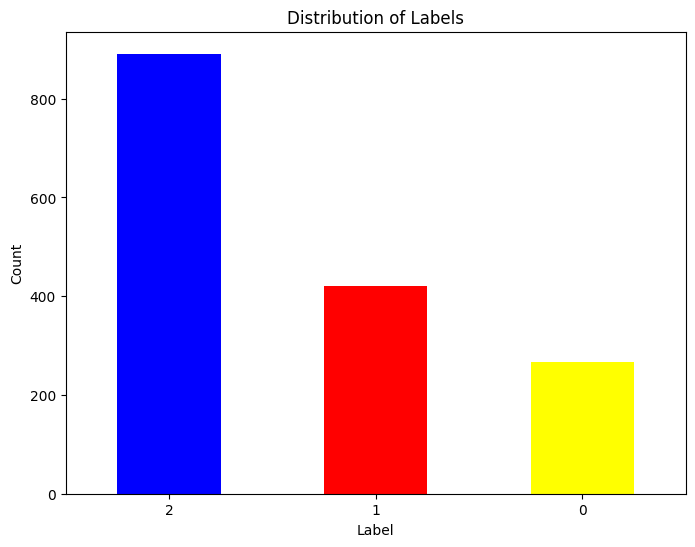

In [4]:
df = pd.DataFrame(labels, columns=['Label'])

# Count the occurrences of each label
label_counts = df['Label'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['blue', 'red', 'yellow'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [5]:
# shuffle the image and labels 
combined_images_labels = list(zip(images, labels))

np.random.shuffle(combined_images_labels)

# Separate them back into images and labels
shuffled_images, shuffled_labels = zip(*combined_images_labels)

# Convert them back to numpy arrays if needed
shuffled_images = np.array(shuffled_images)
shuffled_labels = np.array(shuffled_labels)


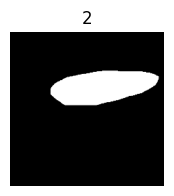

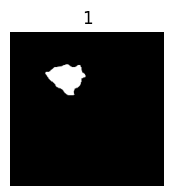

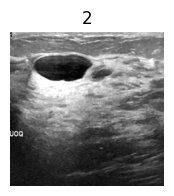

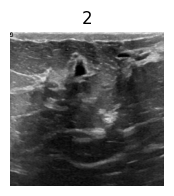

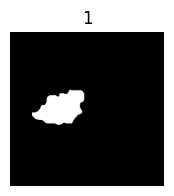

In [6]:
# display some images with their labels

def display_images(images, labels, num_images=5):
    # Limit the number of images to display
    num_images = min(num_images, len(images))

    for i in range(num_images):
        plt.figure(figsize=(2, 2))
        plt.imshow(images[i], cmap='gray')  # Display the image (use cmap='gray' for grayscale)
        plt.title(labels[i])                # Display the label as the title
        plt.axis('off')                     # Turn off the axis
        plt.show()

# Display some images with their labels
display_images(shuffled_images, shuffled_labels)

In [7]:
def glcm_extraction(images): 
    image_data = pd.DataFrame()
    for image in images: 
        df = pd.DataFrame()
        
        distance = [[1], [3], [5], [3], [3], [7]]
        angles = [[0], [0], [0], [np.pi/4], [np.pi/2]]

        for n, (dist, angle) in enumerate(zip(distance, angles)): 
            glcm = graycomatrix(image, dist, angle)
            glcm_e = graycoprops(glcm, 'energy')[0]
            df['Energy'+str(n)] = glcm_e
            glcm_corr = graycoprops(glcm, 'correlation')[0]
            df['Corr'+str(n)] = glcm_corr       
            glcm_diss = graycoprops(glcm, 'dissimilarity')[0]
            df['Diss_sim'+str(n)] = glcm_diss       
            glcm_homm = graycoprops(glcm, 'homogeneity')[0]
            df['Homogen'+str(n)] = glcm_homm       
            glcm_contr = graycoprops(glcm, 'contrast')[0]
            df['Contrast'+str(n)] = glcm_contr
        
        image_data = pd.concat([image_data, df], ignore_index=True)

    return image_data 

In [8]:
# split into training, test and validation

train_images, val_images, train_labels, val_labels = train_test_split(shuffled_images, shuffled_labels, test_size=0.2, random_state=43)

val_images, test_images, val_labels, test_labels = train_test_split(val_images, val_labels, test_size=0.2, random_state=43)

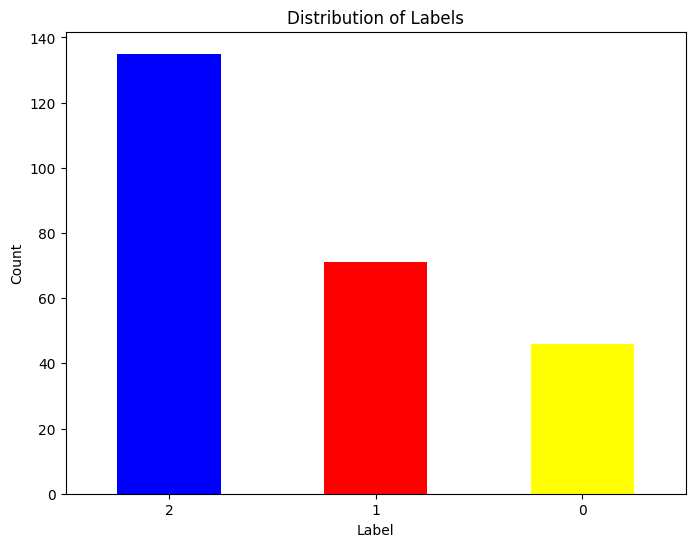

In [9]:
df = pd.DataFrame(val_labels, columns=['Label'])

# Count the occurrences of each label
label_counts = df['Label'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['blue', 'red', 'yellow'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

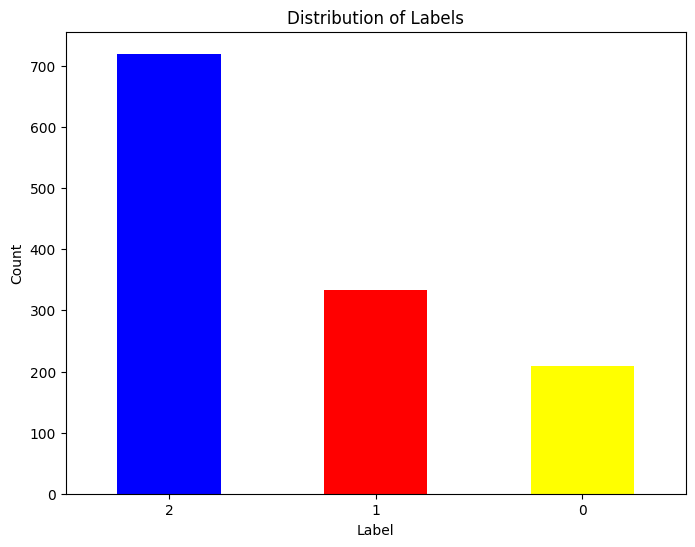

In [10]:
df = pd.DataFrame(train_labels, columns=['Label'])

# Count the occurrences of each label
label_counts = df['Label'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['blue', 'red', 'yellow'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

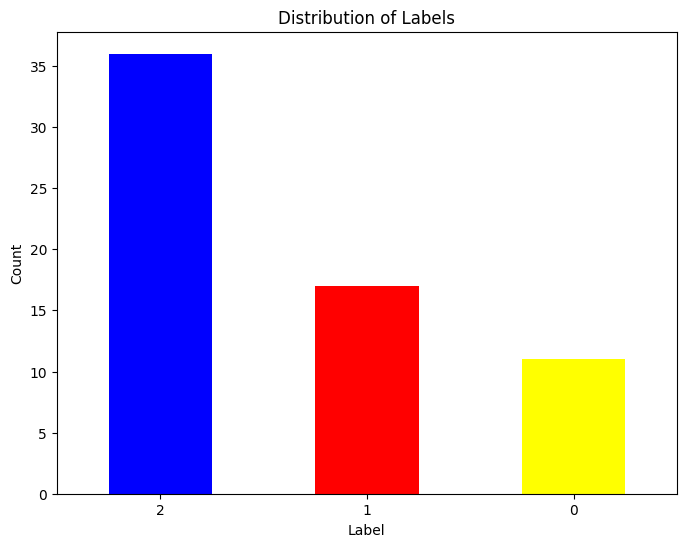

In [11]:
df = pd.DataFrame(test_labels, columns=['Label'])

# Count the occurrences of each label
label_counts = df['Label'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['blue', 'red', 'yellow'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [12]:
print("train:",train_images.shape[0])
print("val:", val_images.shape[0])
print("test:",test_images.shape[0])

train: 1262
val: 252
test: 64


In [13]:
# glcm extraction 
train_features = glcm_extraction(train_images)

In [14]:
val_features = glcm_extraction(val_images)

In [15]:
test_features = glcm_extraction(test_images)

In [16]:
# convert from integers to floats
train_images_norm = train_images.astype('float32')
val_images_norm = val_images.astype('float32')
test_images_norm = test_images.astype('float32')
# normalize to the range 0-1
train_images_norm /= 255.0
val_images_norm /= 255.0
test_images_norm /= 255.0

In [17]:
pd.set_option("display.max_columns", None)
train_features.head()

,Energy0,Corr0,Diss_sim0,Homogen0,Contrast0,Energy1,Corr1,Diss_sim1,Homogen1,Contrast1,Energy2,Corr2,Diss_sim2,Homogen2,Contrast2,Energy3,Corr3,Diss_sim3,Homogen3,Contrast3,Energy4,Corr4,Diss_sim4,Homogen4,Contrast4
0,0.911244,0.981017,0.975777,0.993847,200.010971,0.906243,0.934240,2.953822,0.985853,698.498424,0.901232,0.887252,4.959189,0.977855,1207.445328,0.907568,0.953081,2.186957,0.988712,500.372048,0.908400,0.958345,1.956892,0.989677,442.458508
1,0.017407,0.972393,5.997998,0.182872,126.667601,0.012761,0.919267,12.257474,0.099780,371.296622,0.011871,0.887375,15.128588,0.084154,518.845197,0.012140,0.866824,15.741113,0.085941,606.205726,0.011643,0.842657,17.668633,0.077321,712.387969
2,0.017006,0.994240,4.743814,0.197817,40.716268,0.011908,0.968272,11.017372,0.097867,224.173683,0.010886,0.944494,14.374123,0.079479,392.547313,0.010786,0.932699,15.260855,0.080552,469.628561,0.010310,0.918508,17.237193,0.069640,572.560278
3,0.986617,0.969560,0.245035,0.998367,48.458240,0.985517,0.891877,0.741758,0.996367,173.663138,0.984400,0.813345,1.247554,0.994377,302.499592,0.985188,0.874217,0.855978,0.995904,202.917296,0.984866,0.843198,1.047350,0.995155,251.848578
4,0.027978,0.986586,4.860926,0.214981,87.236167,0.021360,0.966525,9.310702,0.125638,217.820802,0.021249,0.955317,10.940945,0.120963,290.954807,0.021359,0.957544,10.470761,0.121832,272.891141,0.020862,0.949018,11.627949,0.114793,329.689964


In [18]:
train_features.shape

(1262, 25)

In [19]:
# create model and model parameters 
BATCH_SIZE = 16 
EPOCHS = 75
STEP_SIZE = 78

LEARNING_RATE = 0.0001

In [20]:
def create_combined_model(learning_rate=float(LEARNING_RATE)): 
    features = Input(shape=(25,))
    x1 = keras.layers.Dense(32, activation='relu')(features)
    x1 = keras.layers.Dense(16, activation='relu')(x1)

    cnn_input = Input((224,224,1))
    x2 = keras.layers.Conv2D(filters=512, kernel_size=4, strides=2, activation='relu')(cnn_input) 
    x2 = keras.layers.BatchNormalization()(x2)
    x2 = keras.layers.MaxPool2D(pool_size=(2,2))(x2)
    x2 = keras.layers.Dropout(0.2)(x2)
    
    x2 = keras.layers.Conv2D(filters=256, kernel_size=4, strides=1, activation='relu')(x2)
    x2 = keras.layers.BatchNormalization()(x2)
    x2 = keras.layers.MaxPool2D(pool_size=(2,2))(x2)
    x2 = keras.layers.Dropout(0.2)(x2)

    x2 = keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, activation='relu')(x2)
    x2 = keras.layers.BatchNormalization()(x2)
    x2 = keras.layers.MaxPool2D(pool_size=(2,2))(x2)
    x2 = keras.layers.Dropout(0.2)(x2)

    x2 = keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, activation='relu')(x2)
    x2 = keras.layers.BatchNormalization()(x2)
    x2 = keras.layers.MaxPool2D(pool_size=(2,2))(x2)
    x2 = keras.layers.Dropout(0.2)(x2)

    x2 = keras.layers.Flatten()(x2)
    
    combined = keras.layers.Concatenate()([x1,x2])

    x = keras.layers.Dense(16, activation='relu')(combined)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(8, activation='relu')(x)
    x = keras.layers.Dense(6, activation='relu')(x)
    x = keras.layers.Dense(3, activation='softmax')(x)

    model = keras.Model([features, cnn_input], x)

    print(model.summary())

    aopt = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=aopt, loss=keras.losses.SparseCategoricalCrossentropy(), 
                    metrics=[keras.metrics.SparseCategoricalAccuracy()])
    
    return model


In [21]:
model = create_combined_model()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │      8,704 │ input_layer_1[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │      2,048 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 55, 55,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 55, 55,    │          0 │ max_pooling2d[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 52, 52,    │  2,097,408 │ dropout[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │      1,024 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 26, 26,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 26, 26,    │          0 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 24, 24,    │    295,040 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 12, 12,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 12, 12,    │          0 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 10, 10,    │     73,792 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 10,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 5, 5, 64)  │          0 │ batch_normalizat

 Total params: 2,506,291 (9.56 MB)

 Trainable params: 2,504,339 (9.55 MB)

 Non-trainable params: 1,952 (7.62 KB)

None


In [22]:
callb = [
    ModelCheckpoint(
        'glcm_cnn_model_best.keras', 
        monitor='val_sparse_categorical_accuracy', 
        verbose=1, 
        save_best_only=True, 
        mode='max'),
        ]

In [23]:
# Create training, validation and test datasets

data_inputs = tf.data.Dataset.from_tensor_slices((train_features, tf.expand_dims(train_images_norm, axis=-1)))
data_labels = tf.data.Dataset.from_tensor_slices(train_labels)

val_inputs = tf.data.Dataset.from_tensor_slices((val_features, tf.expand_dims(val_images_norm, axis=-1)))
val_labels = tf.data.Dataset.from_tensor_slices(val_labels)

test_inputs = tf.data.Dataset.from_tensor_slices((test_features, tf.expand_dims(test_images_norm, axis=-1)))
test_labels_ds = tf.data.Dataset.from_tensor_slices(test_labels)

test_dataset = tf.data.Dataset.zip((test_inputs, test_labels_ds)).batch(BATCH_SIZE).repeat()

val_dataset = tf.data.Dataset.zip((val_inputs, val_labels)).batch(BATCH_SIZE).repeat()

dataset = tf.data.Dataset.zip((data_inputs, data_labels)).batch(BATCH_SIZE).repeat()

In [24]:
for inputs, labels in dataset.take(1):
    print("Inputs type:", inputs[0].dtype)
    print("Labels type:", labels.dtype)

Inputs type: <dtype: 'float64'>
Labels type: <dtype: 'int64'>


In [25]:
# run model
history_v1 = model.fit(dataset, validation_data=val_dataset, validation_steps=(len(val_features) // BATCH_SIZE) ,epochs=EPOCHS, steps_per_epoch=STEP_SIZE, callbacks=callb)

Epoch 1/75


I0000 00:00:1725984361.479088     141 service.cc:145] XLA service 0x79b078004fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725984361.479159     141 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 2/78 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 1.2928 - sparse_categorical_accuracy: 0.1094  

I0000 00:00:1725984397.296860     141 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.1769 - sparse_categorical_accuracy: 0.2563
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.35833, saving model to glcm_cnn_model_best.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 47s 85ms/step - loss: 1.1762 - sparse_categorical_accuracy: 0.2570 - val_loss: 1.1046 - val_sparse_categorical_accuracy: 0.3583
Epoch 2/75
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1.0368 - sparse_categorical_accuracy: 0.3900
Epoch 2: val_sparse_categorical_accuracy did not improve from 0.35833
78/78 ━━━━━━━━━━━━━━━━━━━━ 37s 95ms/step - loss: 1.0365 - sparse_categorical_accuracy: 0.3903 - val_loss: 1.1467 - val_sparse_categorical_accuracy: 0.1441
Epoch 3/75
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.9772 - sparse_categorical_accuracy: 0.4911
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.35833
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.9771 - sparse_categorical_accuracy: 0.4911 - val_loss: 1.1368 - val_sparse_categorica

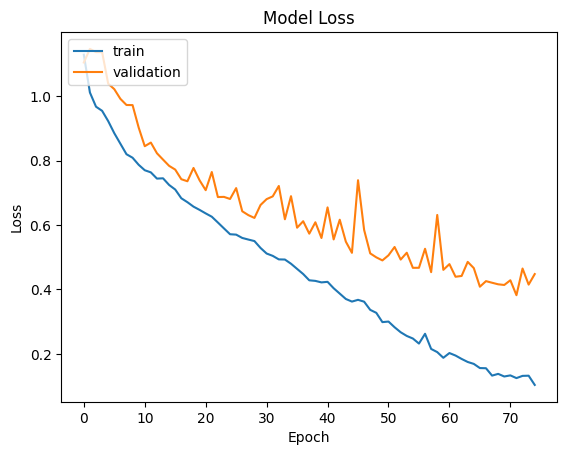

In [31]:
plt.plot(history_v1.history['loss'])
plt.plot(history_v1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'],loc='upper left')

plt.show()

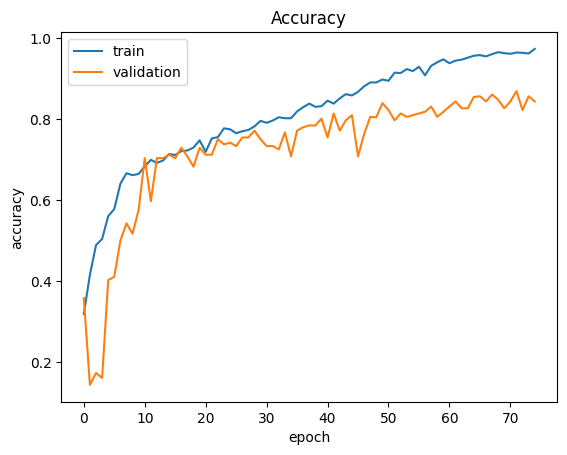

In [32]:
plt.plot(history_v1.history['sparse_categorical_accuracy'])
plt.plot(history_v1.history['val_sparse_categorical_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [33]:
# test set 

STEP_SIZE_TEST = test_images_norm.shape[0]//BATCH_SIZE

score = model.evaluate(test_dataset, batch_size=BATCH_SIZE, steps=STEP_SIZE_TEST )
print(f'Test loss: {score[0]} / Test sparse accuracy: {score[1]}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5364 - sparse_categorical_accuracy: 0.7917
Test loss: 0.5340617299079895 / Test sparse accuracy: 0.8125


In [34]:
# predictions
preds = model.predict(test_dataset, steps=STEP_SIZE_TEST, batch_size=BATCH_SIZE)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [35]:
from sklearn.preprocessing import LabelBinarizer

# courtesy of sklearn documentation for multiclass ROC 

label_binarizer = LabelBinarizer().fit(test_labels)
y_onehot_test = label_binarizer.transform(test_labels)
y_onehot_test.shape  # (n_samples, n_classes)

(64, 3)

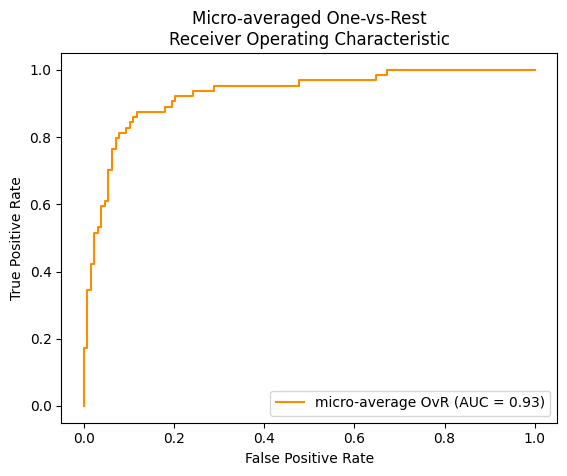

In [48]:
from sklearn.metrics import RocCurveDisplay
display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    preds.ravel(),
    name="micro-average OvR",
    color="darkorange",
    
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)


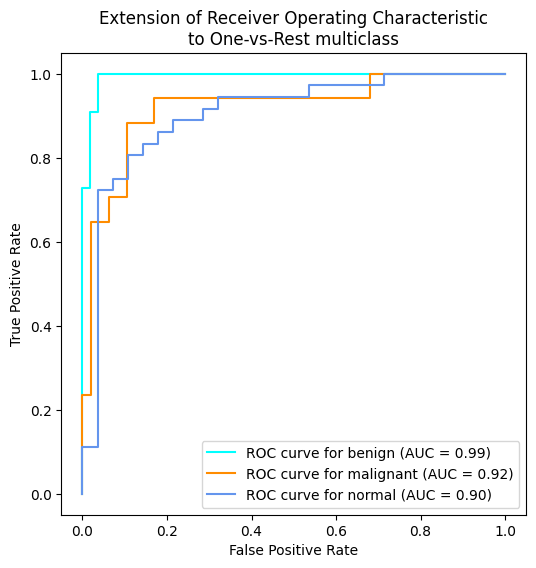

In [53]:
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
target_names=['benign', 'malignant', 'normal']
n_classes=3

fig, ax = plt.subplots(figsize=(6, 6))

for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        preds[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
)



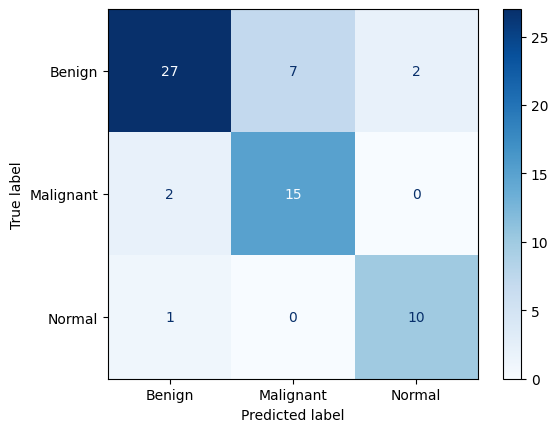

In [56]:
# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predicted_labels = np.argmax(preds, axis=1)

cm = confusion_matrix(test_labels, predicted_labels, labels=[2, 1, 0])

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant", "Normal"])
disp.plot(cmap=plt.cm.Blues, values_format='d')